In [1]:
import numpy as np

# Unknown objective/black box function to Gaussian Process model
def black_box_function(x):
    y = np.squeeze(x * np.sin(x))
    return y

# X is all possible values that the sole parameter can take on
X = np.linspace(start=0, stop=10, num=1_000).reshape(-1, 1)

# True function
y = black_box_function(X)

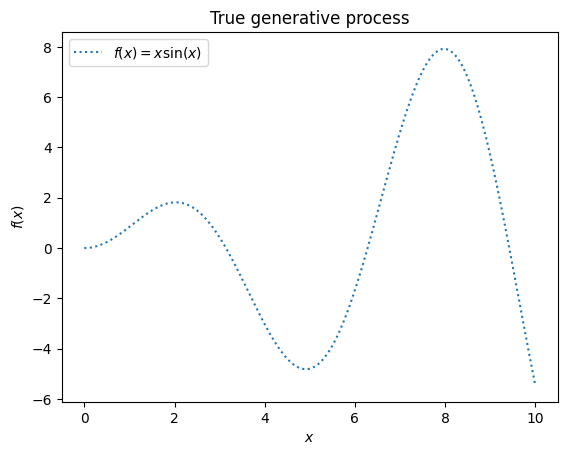

In [2]:
import matplotlib.pyplot as plt

# Plots the true black box function for reference
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("True generative process")

In [3]:
# Observes an initial number of samples of the unknown objective function
rng = np.random.RandomState(2)
training_indices = rng.choice(np.arange(y.size), size=3, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Obtains the kernel for the GP regression model
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fits the GP model with observed values
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

8.08**2 * RBF(length_scale=15.5)

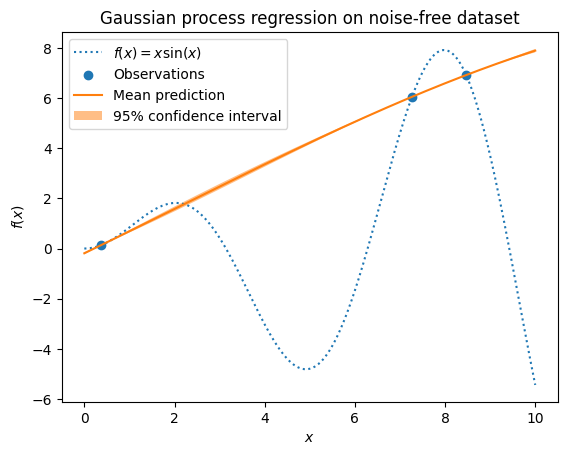

In [5]:
# Obtains the mean of all surrogate function predictions and the
# standard deviation, aka uncertainty
mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

# Plots the first iteration of GP model
plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted")
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
_ = plt.title("Gaussian process regression on noise-free dataset")

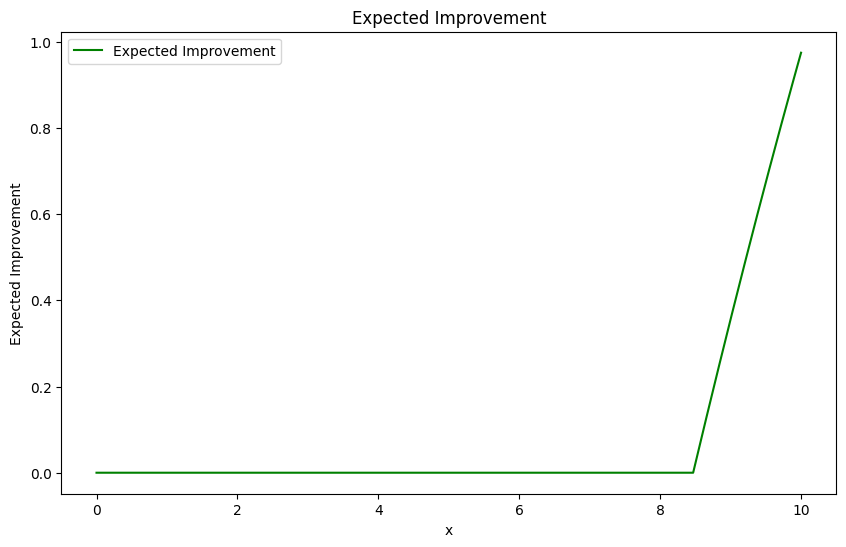

In [6]:
from scipy.stats import norm

# Determines the expected improvement across all values of x
# relative to the best observed y value
def expected_improvement(x, gp_model, best_y):
    y_pred, y_std = gp_model.predict(x.reshape(-1, 1), return_std=True)
    z = (y_pred - best_y) / y_std
    ei = (y_pred - best_y) * norm.cdf(z) + y_std * norm.pdf(z)
    return ei

# Determine the best point with the highest observed function value
best_idx = np.argmax(y_train)
best_x = X_train[best_idx]
best_y = y_train[best_idx]

# Obtain EI of all x values
ei = expected_improvement(X, gaussian_process, best_y)

# Plot the expected improvement
plt.figure(figsize=(10, 6))
plt.plot(X, ei, color='green', label='Expected Improvement')
plt.xlabel('x')
plt.ylabel('Expected Improvement')
plt.title('Expected Improvement')
plt.legend()
plt.show()

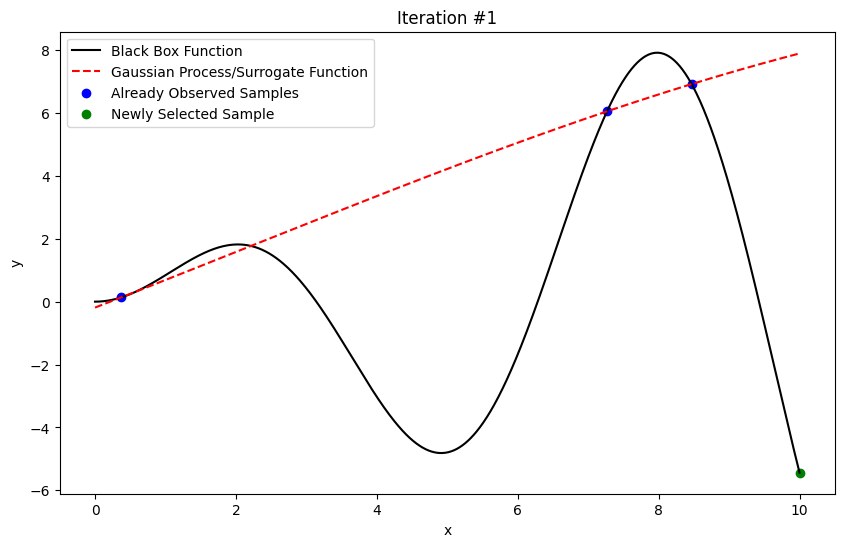

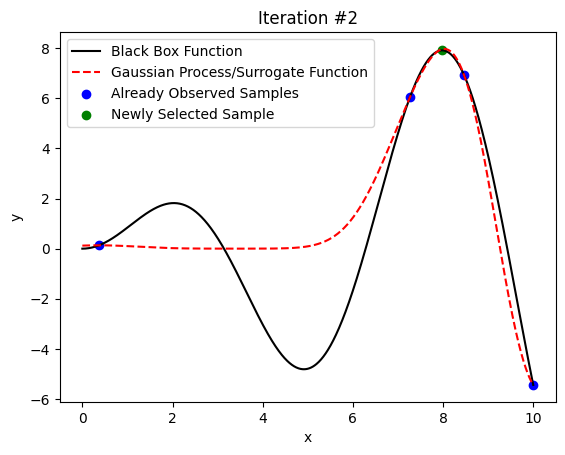

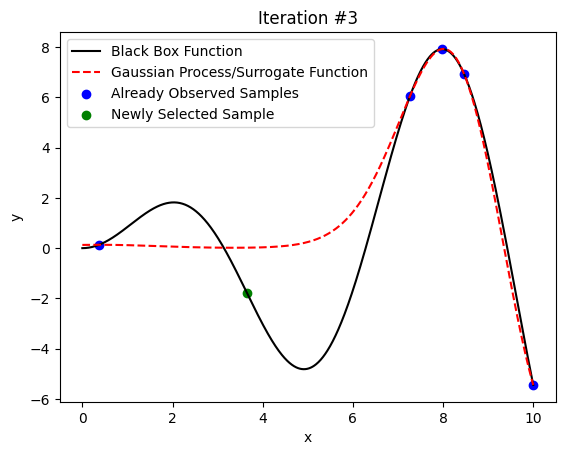

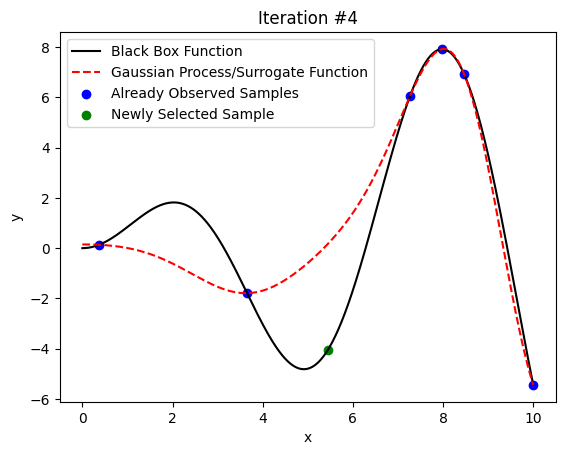

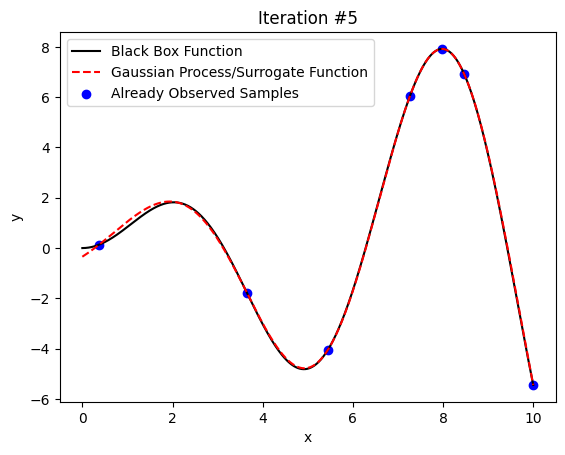

In [7]:
# Iterates through GP a set number of times
num_iterations = 5

plt.figure(figsize=(10, 6))

for i in range(num_iterations):

    # Fit the GP model to the samples
    gaussian_process.fit(X_train.reshape(-1, 1), y_train)

    # Obtains the mean of all surrogate function predictions and the
    # standard deviation, aka uncertainty
    y_pred, y_std = gaussian_process.predict(X.reshape(-1, 1), return_std=True)

    # Determines the best point with the highest observed function value
    best_idx = np.argmax(y_train)
    best_x = X_train[best_idx]
    best_y = y_train[best_idx]

    # Calculates the EI of all potential parameter X values
    ei = expected_improvement(X, gaussian_process, best_y)

    # Plot the black box function, surrogate function, and previously observed samples
    plt.plot(X, black_box_function(X), color='black', label='Black Box Function')
    plt.plot(X, y_pred, color='red', linestyle='dashed', label='Gaussian Process/Surrogate Function')
    plt.scatter(X_train, y_train, color='blue', label='Already Observed Samples')

    if i < num_iterations - 1:
        # Select the next point with the highest EI
        new_x = X[np.argmax(ei)]
        new_y = black_box_function(new_x)
        X_train = np.append(X_train, new_x)
        y_train = np.append(y_train, new_y)

        # Plot the new sample, if selected
        plt.scatter(new_x, new_y, color='green', label='Newly Selected Sample')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f"Iteration #{i+1}")
    plt.legend()
    plt.show()